In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models/DeepCNN.py
/kaggle/input/models/cnn_gru_hybridmodel.py
/kaggle/input/models/cnn_variation.py
/kaggle/input/condition-monitoring-dataset-ai4i-2021/description.txt
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Frequency Features/frequencyFeatures.csv
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/04_out_raw.csv
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/01_off_raw.csv
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/02_on_raw.csv
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/01_off_audio.wav
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/07_c75_raw.csv
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/02_on_audio.wav
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/06_c25_hrm.csv
/kaggle/input/condition-monitoring-dataset-ai4i-2021/Time Series Data/05_unb_audio.wav
/kaggle/input/condition-monitoring-data

In [ ]:
# importing libraries
import numpy as np
import pandas as pd

import foressment_ai as foras

%matplotlib inline

In [ ]:
df = pd.read_csv('/kaggle/input/condition-monitoring-dataset-ai4i-2021/Frequency Features/frequencyFeatures.csv')
df.head()

,ID,Label,Timestamp,xAcc010Hz,xAcc015Hz,xAcc020Hz,xAcc025Hz,xAcc030Hz,xAcc035Hz,xAcc040Hz,...,snd2275Hz,snd2300Hz,snd2325Hz,snd2350Hz,snd2375Hz,snd2400Hz,snd2425Hz,snd2450Hz,snd2475Hz,snd2500Hz
0,1,off,0.00,10.559710,9.695637,2.036690,2.288568,2.565607,2.312750,3.991020,...,0.004249,0.099368,0.012296,0.008071,0.005442,0.026792,0.013993,0.031688,0.007489,0.013386
1,1,off,0.04,2.420781,7.811703,2.076250,2.885846,2.186312,1.296386,2.937785,...,0.013465,0.089160,0.018883,0.018947,0.010409,0.013679,0.017798,0.018390,0.018145,0.007316
2,1,off,0.08,4.148815,6.011957,4.847633,1.743515,1.342447,2.574446,2.829619,...,0.016140,0.075694,0.025835,0.017859,0.015873,0.004619,0.032514,0.008647,0.034637,0.005606
3,1,off,0.12,1.893998,4.014839,9.151205,5.658958,3.151961,3.148572,5.322784,...,0.007497,0.072591,0.031014,0.008861,0.017935,0.000610,0.046791,0.006037,0.028448,0.014418
4,1,off,0.16,7.347695,7.796385,13.865880,11.953800,7.163614,3.821749,9.075362,...,0.019350,0.066571,0.028685,0.034594,0.016541,0.018063,0.035644,0.007217,0.014886,0.024236


In [ ]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 2000 rows and 172 columns


In [ ]:
df['Label'].value_counts()

Label
off    250
on     250
cap    250
out    250
unb    250
c25    250
c75    250
vnt    250
Name: count, dtype: int64

In [ ]:
# separating the independent and dependent variables
x = df.iloc[:,2:]
y = df['Label']

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
sc = StandardScaler()
x = sc.fit_transform(x)
print(np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
print(np.unique(y))

['c25' 'c75' 'cap' 'off' 'on' 'out' 'unb' 'vnt']
[0 1 2 3 4 5 6 7]


In [ ]:
# Splitting data into train and test data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,train_size=0.75,stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1500, 170)
(500, 170)
(1500,)
(500,)


# Model
In this section, all models are tested; except for the hybrid model with CNN+GRU layers, all others received good results.

In [ ]:
import sys
sys.path.insert(1, '/kaggle/input/models/')
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Recall, Precision, AUC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## CNN

In [ ]:
classes = 8
batch_size=128

In [ ]:
import optuna

def create_model(trial):
    blocks = trial.suggest_int("blocks", 1, 2)
    units = trial.suggest_int("units", 32, 256, step=32)

    model = foras.DeepCNN(input_shape=(X_train.shape[1],1), blocks=blocks, units=units, classes=classes)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size,
              validation_data=(X_test, y_test))
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best blocks:", study.best_trial.params["blocks"])
print("Best units:", study.best_trial.params["units"])

[I 2024-08-26 11:36:20,742] A new study created in memory with name: no-name-876b8cd4-ec26-4016-86fd-e9431d6320da
I0000 00:00:1724672185.183413      67 service.cc:145] XLA service 0x7c0a40002580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724672185.183467      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724672188.933323      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3876 - auc: 0.7860 - loss: 1.8067 - precision: 0.2164 - recall: 0.8477


[I 2024-08-26 11:36:35,478] Trial 0 finished with value: 0.36000001430511475 and parameters: {'blocks': 2, 'units': 192}. Best is trial 0 with value: 0.36000001430511475.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7461 - auc: 0.9478 - loss: 1.3408 - precision_1: 0.1886 - recall_1: 0.9915


[I 2024-08-26 11:36:44,904] Trial 1 finished with value: 0.7559999823570251 and parameters: {'blocks': 1, 'units': 128}. Best is trial 1 with value: 0.7559999823570251.
I0000 00:00:1724672210.608602      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion_1', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3587 - auc: 0.7457 - loss: 1.8003 - precision_2: 0.1980 - recall_2: 0.7562


[I 2024-08-26 11:36:56,214] Trial 2 finished with value: 0.3700000047683716 and parameters: {'blocks': 2, 'units': 64}. Best is trial 1 with value: 0.7559999823570251.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5696 - auc: 0.8489 - loss: 1.7681 - precision_3: 0.3814 - recall_3: 0.7395


[I 2024-08-26 11:37:08,677] Trial 3 finished with value: 0.5759999752044678 and parameters: {'blocks': 2, 'units': 96}. Best is trial 1 with value: 0.7559999823570251.
2024-08-26 11:37:13.989226: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[256,256,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,1,85]{3,2,1,0}, f32[256,128,1,85]{3,2,1,0}), window={size=1x85 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-26 11:37:14.038974: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.049872498s
Trying algorithm eng3{k11=2} for conv (f32[256,256,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,1,85]{3,2,1,0}, f32[256,128,1,85]{3,2,1,0}), window={size=1x85

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3941 - auc: 0.8308 - loss: 1.8059 - precision_4: 0.2233 - recall_4: 0.9366


[I 2024-08-26 11:37:22,413] Trial 4 finished with value: 0.4000000059604645 and parameters: {'blocks': 2, 'units': 256}. Best is trial 1 with value: 0.7559999823570251.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7094 - auc: 0.9487 - loss: 1.3825 - precision_5: 0.1773 - recall_5: 1.0000


[I 2024-08-26 11:37:31,531] Trial 5 finished with value: 0.7200000286102295 and parameters: {'blocks': 1, 'units': 224}. Best is trial 1 with value: 0.7559999823570251.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7774 - auc: 0.9648 - loss: 1.2844 - precision_6: 0.2102 - recall_6: 1.0000


[I 2024-08-26 11:37:38,071] Trial 6 finished with value: 0.7820000052452087 and parameters: {'blocks': 1, 'units': 128}. Best is trial 6 with value: 0.7820000052452087.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5709 - auc: 0.8382 - loss: 1.7024 - precision_7: 0.2076 - recall_7: 0.8394


[I 2024-08-26 11:37:49,227] Trial 7 finished with value: 0.5640000104904175 and parameters: {'blocks': 2, 'units': 128}. Best is trial 6 with value: 0.7820000052452087.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8212 - auc: 0.9723 - loss: 1.3183 - precision_8: 0.2258 - recall_8: 1.0000


[I 2024-08-26 11:37:57,289] Trial 8 finished with value: 0.8360000252723694 and parameters: {'blocks': 1, 'units': 192}. Best is trial 8 with value: 0.8360000252723694.
2024-08-26 11:38:02.870384: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[160,160,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,92,1,170]{3,2,1,0}, f32[160,92,1,170]{3,2,1,0}), window={size=1x170 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-26 11:38:03.255660: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.385384338s
Trying algorithm eng3{k11=2} for conv (f32[160,160,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,92,1,170]{3,2,1,0}, f32[160,92,1,170]{3,2,1,0}), window={size=1x

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7824 - auc: 0.9516 - loss: 1.3808 - precision_9: 0.2651 - recall_9: 0.9647


[I 2024-08-26 11:38:07,429] Trial 9 finished with value: 0.800000011920929 and parameters: {'blocks': 1, 'units': 160}. Best is trial 8 with value: 0.8360000252723694.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8569 - auc: 0.9735 - loss: 1.2530 - precision_10: 0.3001 - recall_10: 1.0000


[I 2024-08-26 11:38:15,539] Trial 10 finished with value: 0.8920000195503235 and parameters: {'blocks': 1, 'units': 32}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8481 - auc: 0.9795 - loss: 1.2863 - precision_11: 0.2958 - recall_11: 1.0000


[I 2024-08-26 11:38:21,953] Trial 11 finished with value: 0.8659999966621399 and parameters: {'blocks': 1, 'units': 32}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8676 - auc: 0.9809 - loss: 1.2173 - precision_12: 0.2438 - recall_12: 1.0000


[I 2024-08-26 11:38:28,956] Trial 12 finished with value: 0.8880000114440918 and parameters: {'blocks': 1, 'units': 32}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8424 - auc: 0.9772 - loss: 1.2152 - precision_13: 0.2260 - recall_13: 1.0000


[I 2024-08-26 11:38:35,387] Trial 13 finished with value: 0.8700000047683716 and parameters: {'blocks': 1, 'units': 32}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8255 - auc: 0.9756 - loss: 1.2516 - precision_14: 0.3516 - recall_14: 1.0000


[I 2024-08-26 11:38:43,008] Trial 14 finished with value: 0.8479999899864197 and parameters: {'blocks': 1, 'units': 64}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8289 - auc: 0.9537 - loss: 1.3715 - precision_15: 0.2752 - recall_15: 0.9520


[I 2024-08-26 11:38:49,430] Trial 15 finished with value: 0.8460000157356262 and parameters: {'blocks': 1, 'units': 64}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8606 - auc: 0.9770 - loss: 1.3918 - precision_16: 0.3182 - recall_16: 0.9902


[I 2024-08-26 11:38:55,804] Trial 16 finished with value: 0.8820000290870667 and parameters: {'blocks': 1, 'units': 32}. Best is trial 10 with value: 0.8920000195503235.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9203 - auc: 0.9875 - loss: 1.2319 - precision_17: 0.2361 - recall_17: 1.0000


[I 2024-08-26 11:39:04,432] Trial 17 finished with value: 0.9300000071525574 and parameters: {'blocks': 1, 'units': 96}. Best is trial 17 with value: 0.9300000071525574.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8104 - auc: 0.9770 - loss: 1.2190 - precision_18: 0.2941 - recall_18: 1.0000


[I 2024-08-26 11:39:11,043] Trial 18 finished with value: 0.8140000104904175 and parameters: {'blocks': 1, 'units': 96}. Best is trial 17 with value: 0.9300000071525574.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8776 - auc: 0.9785 - loss: 1.2173 - precision_19: 0.2872 - recall_19: 0.9852


[I 2024-08-26 11:39:17,681] Trial 19 finished with value: 0.8820000290870667 and parameters: {'blocks': 1, 'units': 96}. Best is trial 17 with value: 0.9300000071525574.


Best blocks: 1
Best units: 96


In [ ]:
model_one = foras.DeepCNN(input_shape=(X_train.shape[1],1), blocks=study.best_trial.params["blocks"], units=study.best_trial.params["units"], classes=classes)
hist_train = model_one.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=batch_size, verbose=0)

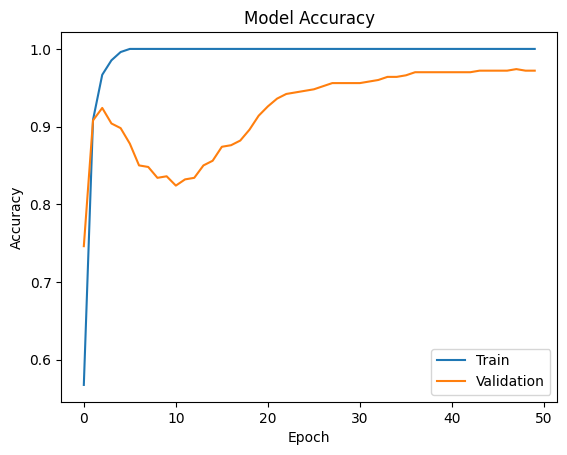

In [ ]:
model_one.draw_plot(plot_type="accuracy")

In [ ]:
model_one.test(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9614 - auc: 0.9886 - loss: 0.1036 - precision_20: 0.2984 - recall_20: 1.0000


[0.08128953725099564,
 0.972000002861023,
 1.0,
 0.3003003001213074,
 0.9882684946060181]

In [ ]:
model_one.print_classification_report(X_test, y_test) #['c25' 'c75' 'cap' 'off' 'on' 'out' 'unb' 'vnt']

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        63
           1       0.92      0.92      0.92        63
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00        63
           6       0.98      0.94      0.96        62
           7       1.00      0.98      0.99        62

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



## CNN+GRU
This model underperforms compared to other models.

In [ ]:
import optuna

def create_model(trial):
    units = trial.suggest_int("units", 32, 256, step=32)
    model = foras.Hybrid_CNN_GRU(input_shape=(X_train.shape[1],1), units=units, classes=classes)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5,
              validation_data=(X_test, y_test), batch_size=batch_size)
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best units:", study.best_trial.params["units"])

[I 2024-08-26 11:39:30,272] A new study created in memory with name: no-name-6338e01e-25b2-463c-82fb-fd87242932cf


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2477 - auc: 0.6003 - loss: 2.0214 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00


[I 2024-08-26 11:39:44,616] Trial 0 finished with value: 0.25 and parameters: {'units': 256}. Best is trial 0 with value: 0.25.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2442 - auc: 0.5896 - loss: 1.9854 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00


[I 2024-08-26 11:39:52,693] Trial 1 finished with value: 0.24799999594688416 and parameters: {'units': 96}. Best is trial 0 with value: 0.25.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2485 - auc: 0.6742 - loss: 1.9827 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00


[I 2024-08-26 11:40:02,811] Trial 2 finished with value: 0.2540000081062317 and parameters: {'units': 192}. Best is trial 2 with value: 0.2540000081062317.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3274 - auc: 0.7330 - loss: 1.9946 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00


[I 2024-08-26 11:40:09,708] Trial 3 finished with value: 0.3100000023841858 and parameters: {'units': 32}. Best is trial 3 with value: 0.3100000023841858.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2639 - auc: 0.6069 - loss: 1.9859 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00


[I 2024-08-26 11:40:17,774] Trial 4 finished with value: 0.2639999985694885 and parameters: {'units': 128}. Best is trial 3 with value: 0.3100000023841858.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1535 - auc: 0.5794 - loss: 2.0207 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00


[I 2024-08-26 11:40:27,981] Trial 5 finished with value: 0.16599999368190765 and parameters: {'units': 224}. Best is trial 3 with value: 0.3100000023841858.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2651 - auc: 0.6008 - loss: 1.9936 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00


[I 2024-08-26 11:40:35,440] Trial 6 finished with value: 0.2680000066757202 and parameters: {'units': 128}. Best is trial 3 with value: 0.3100000023841858.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2070 - auc: 0.6104 - loss: 1.9905 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00


[I 2024-08-26 11:40:44,125] Trial 7 finished with value: 0.2240000069141388 and parameters: {'units': 128}. Best is trial 3 with value: 0.3100000023841858.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1124 - auc: 0.5613 - loss: 2.0467 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00


[I 2024-08-26 11:40:52,548] Trial 8 finished with value: 0.12399999797344208 and parameters: {'units': 192}. Best is trial 3 with value: 0.3100000023841858.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1445 - auc: 0.6056 - loss: 1.9932 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00


[I 2024-08-26 11:40:59,895] Trial 9 finished with value: 0.15600000321865082 and parameters: {'units': 64}. Best is trial 3 with value: 0.3100000023841858.


Best units: 32


In [ ]:
hybrid_classifier = foras.Hybrid_CNN_GRU(input_shape=(X_train.shape[1],1), units=study.best_trial.params["units"], classes=classes)
hist_train = hybrid_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=batch_size, verbose=0)

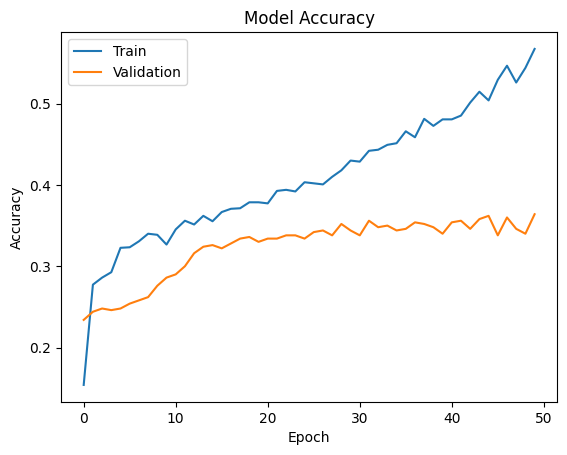

In [ ]:
hybrid_classifier.draw_plot(plot_type="accuracy")

In [ ]:
hybrid_classifier.test(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3735 - auc: 0.7546 - loss: 1.6778 - precision_31: 0.8320 - recall_31: 0.1556


[1.648203730583191,
 0.36399999260902405,
 0.16200000047683716,
 0.7570093274116516,
 0.7653520107269287]

In [ ]:
hybrid_classifier.print_classification_report(X_test, y_test) #['c25' 'c75' 'cap' 'off' 'on' 'out' 'unb' 'vnt']

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.25      0.03      0.06        63
           1       0.23      0.33      0.27        63
           2       0.22      0.21      0.21        63
           3       1.00      1.00      1.00        62
           4       0.31      0.60      0.40        62
           5       0.28      0.43      0.34        63
           6       0.40      0.23      0.29        62
           7       0.20      0.10      0.13        62

    accuracy                           0.36       500
   macro avg       0.36      0.36      0.34       500
weighted avg       0.36      0.36      0.34       500



## Variations

In [ ]:
import optuna

def create_model(trial):
    blocks = trial.suggest_int("blocks", 1, 2)
    units = trial.suggest_int("units", 64, 256, step=32)

    model = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=units, classes=classes, block="residual", loop_number=blocks)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size,
              validation_data=(X_test, y_test))
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best blocks:", study.best_trial.params["blocks"])
print("Best units:", study.best_trial.params["units"])

[I 2024-08-26 11:41:18,005] A new study created in memory with name: no-name-fc26f246-15a7-41fb-8a02-6cec9c50129f


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9277 - auc: 0.9956 - loss: 0.7254 - precision_32: 0.9991 - recall_32: 0.5154


[I 2024-08-26 11:41:29,373] Trial 0 finished with value: 0.9459999799728394 and parameters: {'blocks': 1, 'units': 96}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6954 - auc: 0.9666 - loss: 1.0011 - precision_33: 0.9961 - recall_33: 0.2273


[I 2024-08-26 11:41:44,840] Trial 1 finished with value: 0.6940000057220459 and parameters: {'blocks': 2, 'units': 256}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8646 - auc: 0.9815 - loss: 0.9304 - precision_34: 0.9979 - recall_34: 0.2835


[I 2024-08-26 11:41:58,669] Trial 2 finished with value: 0.8679999709129333 and parameters: {'blocks': 2, 'units': 128}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9144 - auc: 0.9952 - loss: 0.8515 - precision_35: 0.9974 - recall_35: 0.3426


[I 2024-08-26 11:42:11,194] Trial 3 finished with value: 0.9359999895095825 and parameters: {'blocks': 1, 'units': 128}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8513 - auc: 0.9851 - loss: 0.9066 - precision_36: 1.0000 - recall_36: 0.3433


[I 2024-08-26 11:42:24,334] Trial 4 finished with value: 0.8600000143051147 and parameters: {'blocks': 2, 'units': 96}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8788 - auc: 0.9815 - loss: 1.0215 - precision_37: 1.0000 - recall_37: 0.1834


[I 2024-08-26 11:42:37,593] Trial 5 finished with value: 0.8820000290870667 and parameters: {'blocks': 2, 'units': 64}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8480 - auc: 0.9725 - loss: 1.0029 - precision_38: 1.0000 - recall_38: 0.3049


[I 2024-08-26 11:42:50,456] Trial 6 finished with value: 0.8339999914169312 and parameters: {'blocks': 2, 'units': 256}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7445 - auc: 0.9583 - loss: 1.1287 - precision_39: 1.0000 - recall_39: 0.2743


[I 2024-08-26 11:43:04,914] Trial 7 finished with value: 0.7519999742507935 and parameters: {'blocks': 2, 'units': 160}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9094 - auc: 0.9921 - loss: 0.9015 - precision_40: 1.0000 - recall_40: 0.3342


[I 2024-08-26 11:43:16,860] Trial 8 finished with value: 0.921999990940094 and parameters: {'blocks': 1, 'units': 192}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8384 - auc: 0.9869 - loss: 0.9273 - precision_41: 1.0000 - recall_41: 0.3148


[I 2024-08-26 11:43:27,753] Trial 9 finished with value: 0.8579999804496765 and parameters: {'blocks': 1, 'units': 160}. Best is trial 0 with value: 0.9459999799728394.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9476 - auc: 0.9968 - loss: 0.6564 - precision_42: 1.0000 - recall_42: 0.5965


[I 2024-08-26 11:43:38,321] Trial 10 finished with value: 0.9599999785423279 and parameters: {'blocks': 1, 'units': 64}. Best is trial 10 with value: 0.9599999785423279.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9036 - auc: 0.9900 - loss: 0.8317 - precision_43: 0.9912 - recall_43: 0.3941


[I 2024-08-26 11:43:47,939] Trial 11 finished with value: 0.9120000004768372 and parameters: {'blocks': 1, 'units': 64}. Best is trial 10 with value: 0.9599999785423279.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9136 - auc: 0.9879 - loss: 0.8547 - precision_44: 1.0000 - recall_44: 0.3515


[I 2024-08-26 11:43:59,025] Trial 12 finished with value: 0.9240000247955322 and parameters: {'blocks': 1, 'units': 96}. Best is trial 10 with value: 0.9599999785423279.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8742 - auc: 0.9932 - loss: 0.8218 - precision_45: 1.0000 - recall_45: 0.3929


[I 2024-08-26 11:44:08,440] Trial 13 finished with value: 0.9039999842643738 and parameters: {'blocks': 1, 'units': 64}. Best is trial 10 with value: 0.9599999785423279.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9475 - auc: 0.9964 - loss: 0.6780 - precision_46: 0.9938 - recall_46: 0.5505


[I 2024-08-26 11:44:18,005] Trial 14 finished with value: 0.9580000042915344 and parameters: {'blocks': 1, 'units': 96}. Best is trial 10 with value: 0.9599999785423279.


Best blocks: 1
Best units: 64


In [ ]:
hybrid_ = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=study.best_trial.params["units"], classes=classes, block="residual", loop_number=study.best_trial.params["blocks"])
hist_train = hybrid_.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=batch_size, verbose=0)

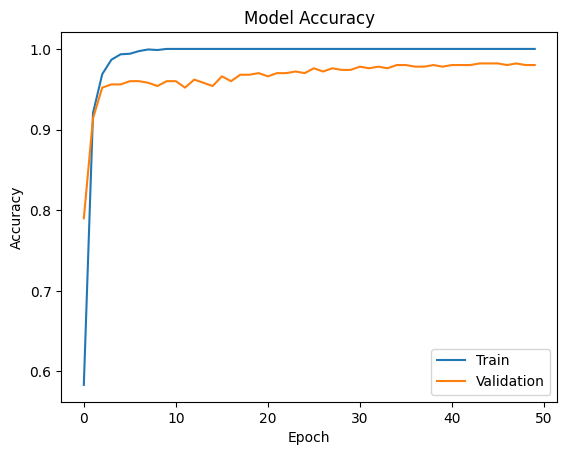

In [ ]:
hybrid_.draw_plot(plot_type="accuracy")

In [ ]:
hybrid_.test(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9696 - auc: 0.9996 - loss: 0.0770 - precision_47: 0.9730 - recall_47: 0.9661


[0.055727921426296234,
 0.9800000190734863,
 0.9739999771118164,
 0.9818548560142517,
 0.9997671842575073]

In [ ]:
hybrid_.print_classification_report(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        63
           1       0.95      0.92      0.94        63
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00        63
           6       1.00      0.97      0.98        62
           7       1.00      1.00      1.00        62

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



In [ ]:
import optuna

def create_model(trial):
    blocks = trial.suggest_int("blocks", 1, 2)
    units = trial.suggest_int("units", 64, 256, step=32)

    model = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=units, classes=classes, block="Xception", loop_number=blocks)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size,
              validation_data=(X_test, y_test))
    val_acc = model.test(X_test, y_test)[1]
    return val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best blocks:", study.best_trial.params["blocks"])
print("Best units:", study.best_trial.params["units"])

[I 2024-08-26 11:44:33,515] A new study created in memory with name: no-name-1b0e049d-9beb-4dd7-bbff-e07016d4dd1c
I0000 00:00:1724672680.328114      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9033 - auc: 0.9933 - loss: 0.8271 - precision_48: 1.0000 - recall_48: 0.4081


[I 2024-08-26 11:44:49,081] Trial 0 finished with value: 0.9179999828338623 and parameters: {'blocks': 1, 'units': 128}. Best is trial 0 with value: 0.9179999828338623.
I0000 00:00:1724672695.673673      67 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8977 - auc: 0.9918 - loss: 0.8225 - precision_49: 1.0000 - recall_49: 0.4342


[I 2024-08-26 11:45:04,245] Trial 1 finished with value: 0.9120000004768372 and parameters: {'blocks': 1, 'units': 192}. Best is trial 0 with value: 0.9179999828338623.
I0000 00:00:1724672711.027623      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8675 - auc: 0.9901 - loss: 0.8177 - precision_50: 0.9929 - recall_50: 0.4164


[I 2024-08-26 11:45:20,040] Trial 2 finished with value: 0.8939999938011169 and parameters: {'blocks': 1, 'units': 224}. Best is trial 0 with value: 0.9179999828338623.
I0000 00:00:1724672728.479631      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion', 4 bytes spill stores, 4 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9103 - auc: 0.9898 - loss: 1.0489 - precision_51: 1.0000 - recall_51: 0.1947


[I 2024-08-26 11:45:38,426] Trial 3 finished with value: 0.9240000247955322 and parameters: {'blocks': 1, 'units': 64}. Best is trial 3 with value: 0.9240000247955322.
2024-08-26 11:45:46.397563: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[256,256,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,1,85]{3,2,1,0}, f32[256,128,1,85]{3,2,1,0}), window={size=1x85}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-08-26 11:45:46.447029: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.049598009s
Trying algorithm eng3{k11=2} for conv (f32[256,256,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,1,85]{3,2,1,0}, f32[256,128,1,85]{3,2,1,0}), window={size=1x85}, dim_label

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7009 - auc: 0.9408 - loss: 1.4918 - precision_52: 0.0000e+00 - recall_52: 0.0000e+00


[I 2024-08-26 11:46:00,749] Trial 4 finished with value: 0.7300000190734863 and parameters: {'blocks': 2, 'units': 192}. Best is trial 3 with value: 0.9240000247955322.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8872 - auc: 0.9912 - loss: 0.9345 - precision_53: 1.0000 - recall_53: 0.2908


[I 2024-08-26 11:46:14,175] Trial 5 finished with value: 0.9120000004768372 and parameters: {'blocks': 1, 'units': 224}. Best is trial 3 with value: 0.9240000247955322.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8884 - auc: 0.9892 - loss: 0.8466 - precision_54: 0.9923 - recall_54: 0.3809


[I 2024-08-26 11:46:26,939] Trial 6 finished with value: 0.8939999938011169 and parameters: {'blocks': 1, 'units': 192}. Best is trial 3 with value: 0.9240000247955322.
I0000 00:00:1724672795.428740      67 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9127 - auc: 0.9918 - loss: 0.8357 - precision_55: 1.0000 - recall_55: 0.3995


[I 2024-08-26 11:46:43,844] Trial 7 finished with value: 0.9160000085830688 and parameters: {'blocks': 1, 'units': 160}. Best is trial 3 with value: 0.9240000247955322.
I0000 00:00:1724672812.473950      67 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion_1', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion', 4 bytes spill stores, 4 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6188 - auc: 0.9115 - loss: 1.3719 - precision_56: 1.0000 - recall_56: 0.1251


[I 2024-08-26 11:47:02,671] Trial 8 finished with value: 0.6420000195503235 and parameters: {'blocks': 2, 'units': 160}. Best is trial 3 with value: 0.9240000247955322.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8939 - auc: 0.9889 - loss: 0.8346 - precision_57: 1.0000 - recall_57: 0.4015


[I 2024-08-26 11:47:15,174] Trial 9 finished with value: 0.9120000004768372 and parameters: {'blocks': 1, 'units': 160}. Best is trial 3 with value: 0.9240000247955322.
I0000 00:00:1724672845.426241      66 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion_1', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion_2', 4 bytes spill stores, 4 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1569 - auc: 0.7944 - loss: 1.8543 - precision_58: 0.2450 - recall_58: 0.1180


[I 2024-08-26 11:47:35,695] Trial 10 finished with value: 0.1720000058412552 and parameters: {'blocks': 2, 'units': 64}. Best is trial 3 with value: 0.9240000247955322.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8957 - auc: 0.9909 - loss: 0.9321 - precision_59: 1.0000 - recall_59: 0.3323


[I 2024-08-26 11:47:47,058] Trial 11 finished with value: 0.8999999761581421 and parameters: {'blocks': 1, 'units': 64}. Best is trial 3 with value: 0.9240000247955322.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8840 - auc: 0.9909 - loss: 0.8354 - precision_60: 1.0000 - recall_60: 0.3996


[I 2024-08-26 11:48:02,605] Trial 12 finished with value: 0.8960000276565552 and parameters: {'blocks': 1, 'units': 96}. Best is trial 3 with value: 0.9240000247955322.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8960 - auc: 0.9921 - loss: 0.8648 - precision_61: 1.0000 - recall_61: 0.3331


[I 2024-08-26 11:48:14,470] Trial 13 finished with value: 0.9100000262260437 and parameters: {'blocks': 1, 'units': 96}. Best is trial 3 with value: 0.9240000247955322.
I0000 00:00:1724672904.638397      67 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_transpose_fusion_2', 4 bytes spill stores, 4 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5314 - auc: 0.8274 - loss: 1.5715 - precision_62: 1.0000 - recall_62: 0.0144


[I 2024-08-26 11:48:35,663] Trial 14 finished with value: 0.5239999890327454 and parameters: {'blocks': 2, 'units': 96}. Best is trial 3 with value: 0.9240000247955322.


Best blocks: 1
Best units: 64


In [ ]:
hybrid_x = foras.hybrid_variation(input_shape=(X_train.shape[1],1), units=study.best_trial.params["units"], classes=classes, block="Xception", loop_number=study.best_trial.params["blocks"])
hist_train = hybrid_x.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=batch_size, verbose=0)

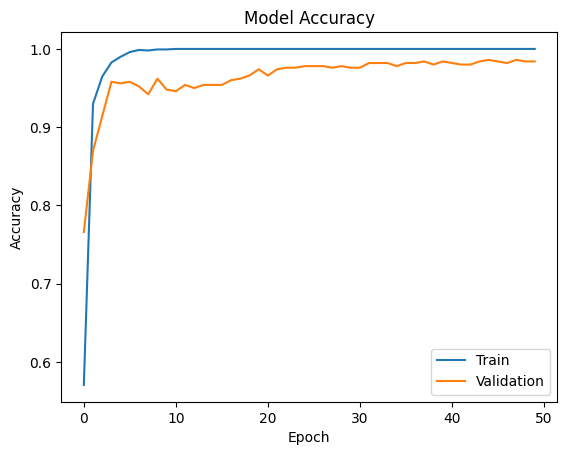

In [ ]:
hybrid_x.draw_plot(plot_type="accuracy")

In [ ]:
hybrid_x.test(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9739 - auc: 0.9996 - loss: 0.0692 - precision_63: 0.9801 - recall_63: 0.9735


[0.0484410785138607,
 0.984000027179718,
 0.9819999933242798,
 0.9859437942504883,
 0.999824583530426]

In [ ]:
hybrid_x.print_classification_report(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        63
           1       0.94      0.97      0.95        63
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00        63
           6       1.00      0.95      0.98        62
           7       1.00      1.00      1.00        62

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500

